# Deep fake detection

In [1]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm #progress meter
%matplotlib inline 
import cv2 
from PIL import Image

import torch # if neural networks
from torch import nn
import torch.nn.functional as F
import torchvision #cnn
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms 
from torch import optim

from sklearn.model_selection import train_test_split

!pip install facenet-pytorch
from facenet_pytorch import MTCNN, InceptionResnetV1

torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data

In [2]:
nDataFolder = 'data'
naTrainFolder = ['train_part0','train_part1',
                 'train_part2','train_part3',
                 'train_part4','train_part5',
                 'train_part6','train_part7',
                 'train_part8','train_part9',
                 'train_part10']

In [3]:
#Train with only first folder to test , this will be a for 
train_df = pd.read_json(os.path.join(nDataFolder, naTrainFolder[0], 'metadata.json'))
train_df = train_df.T
train_df_false = train_df [train_df.label == 'FAKE']
len(train_df_false)#.head()

1248

In [4]:
#train split to split and mix , we only will use the x split
train_videos,eval_videos,train_y,eval_y = train_test_split(train_df_false,train_df_false.label,train_size = 0.8,random_state =3)
#train_videos.head(2)

In [13]:
for video_name,video in train_videos.iterrows():#tqdm(
    print(video.original)
    break

aayrffkzxn.mp4


### Face Data Loader

In [6]:
#iterate for each video 
torch.cuda.empty_cache()
# Load face detector
mtcnn = MTCNN(margin=14, keep_all=True, device=device).eval()
def get_faces (filename, n_frames = 17):
    video_o = cv2.VideoCapture(filename)#get video 
    #get the lenght and divide inthe specified dataframes
    video_len = int(video_o.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_index_list = np.linspace(0, video_len - 1, n_frames).astype(int)
    face_batch = torch.tensor((),dtype = torch.float32)
    for frame_indx in range(video_len):
        if frame_indx in frame_index_list:
            success = video_o.grab()
            success, frame = video_o.retrieve()
            if  success: 
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = Image.fromarray(frame)
                Face = mtcnn(frame) # succes will not be considered to train with noise data too
            else:
                Face = torch.tensor((),dtype = torch.float32)
                Face = Face.new_zeros([1, 3, 160, 160])
                
            if Face is None:
                Face = torch.tensor((),dtype = torch.float32)
                Face = Face.new_zeros([1, 3, 160, 160])
                
            face_batch = torch.cat((face_batch,Face))
            if len(face_batch) > n_frames:
                face_batch  = face_batch[:n_frames]
                
    video_o.release()
    return face_batch



### Model definition Embdeddigns


In [7]:
resnet = InceptionResnetV1(pretrained='vggface2', device=device).eval() 
torch.cuda.empty_cache()
def get_video_embedding(filename,n_frames = 17):
    faces = get_faces(filename,n_frames)
    embe = resnet(faces.to(device))
    return torch.mean(embe,dim = 0)



In [8]:
#test 
filename = os.path.join(nDataFolder, naTrainFolder[0], train_df_false.index[1])
filename_org = os.path.join(nDataFolder, naTrainFolder[0],train_df_false.original[1])
mean_fake = get_video_embedding(filename)
mean_org  = get_video_embedding(filename_org)
mean_fake.shape

torch.Size([512])

### Model Definition Classifier

In [9]:
#Now define the model to output if fake or not 
class FakeClassifier(nn.Module):
    def __init__(self):
        super(FakeClassifier,self).__init__()
        self.hidden0 = nn.Sequential(
            nn.Linear(512,256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3))
        self.hidden1 = nn.Sequential(
            nn.Linear(256,128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3))
        self.hidden2 = nn.Sequential(
            nn.Linear(128,64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3))
        self.hidden3 = nn.Sequential(
            nn.Linear(64,32),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3))
        self.out =  nn.Linear(32,1) #BCELoss
       # self.out =  nn.Linear(32,2) #CrossEntropyLoss
        
    def forward(self,x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.out(x)
        return x

In [15]:
fake_classifier = FakeClassifier().to(device)
classifier_adam_optim = optim.Adam(fake_classifier.parameters(),lr = 0.01)
scheduler = lr_scheduler.StepLR(classifier_adam_optim, step_size=5, gamma=0.1)
criterion_BCE = nn.BCEWithLogitsLoss()
criterion_CEL = nn.CrossEntropyLoss()

### Train

In [16]:
   #iterate for each video 

def train_classifier(epoch,metrics_df):
    last_eval_loss =  1000000000.0
    nFrames = 17
    torch.cuda.empty_cache()
   
    fake_tensor = torch.tensor((),requires_grad = False,dtype = torch.float32)
    true_tensor = torch.tensor((),requires_grad = False,dtype = torch.float32)
    eval_tensor = torch.tensor((),requires_grad = False,dtype = torch.float32)
    folder_cnt = 0
    for train_folder in naTrainFolder:
        print('Folder',train_folder)
        folder_cnt = folder_cnt +1
        #create a df for each train folder in order to use train_test_split
        train_df = pd.read_json(os.path.join(nDataFolder, train_folder, 'metadata.json'))
        train_df = train_df.T
        train_df_false = train_df [train_df.label == 'FAKE']
        train_videos,eval_videos,y_train,eval_y  = train_test_split(train_df_false,train_df_false.label,train_size = 0.7,random_state =3)     
        indx = 0
        
        #train
        train_loss_f= 0
        train_loss_o= 0
        fake_classifier.train()
        for video_name,video in tqdm(train_videos.iterrows()):#tqdm(
            indx = indx +1
            #access the video 
            filename = os.path.join(nDataFolder, train_folder, video_name)
            filename_org = os.path.join(nDataFolder, train_folder,video.original)
            #get the mean embeddings
            mean_fake = get_video_embedding(filename,nFrames)
            mean_org  = get_video_embedding(filename_org,nFrames)
            mean_fake.detach_()
            mean_org.detach_()

            #start train


            classifier_adam_optim.zero_grad()
            out_class = fake_classifier(mean_fake[None].to(device))
            #create fake vector
            fake_tensor = torch.randint_like(out_class,7,12,requires_grad = False,dtype = torch.float32)/10.0
            #fake_tensor = fake_tensor.new_ones(out_class.shape)
            #loss = criterion_CEL(out_class,fake_tensor.to(device))
            loss_f = criterion_BCE(out_class,fake_tensor.to(device))
            loss_f.backward()
            train_loss_f = train_loss_f + loss_f.item()
            #classifier_adam_optim.step()
            #train on true
            #if indx%2 == 0:
            out_class_o = fake_classifier(mean_org[None].to(device))
            #create true tensor
            true_tensor = torch.randint_like(out_class_o,0,3,requires_grad = False,dtype = torch.float32)/10.0
            #true_tensor = true_tensor.new_zeros(out_class_o.shape)
            #loss = criterion_CEL(out_class_o,true_tensor.to(device))
            loss_o = criterion_BCE(out_class_o,true_tensor.to(device))
            loss_o.backward()
            loss_f = loss_f +loss_o
            classifier_adam_optim.step()
            train_loss_o = train_loss_o + loss_o.item()
            
        print('loss on fake videos: ',train_loss_f ,'  loss on original videos: ',train_loss_o)
        metrics_df.loc[epoch + folder_cnt , 'train_loss_fake'] = train_loss_f
        metrics_df.loc[epoch + folder_cnt , 'train_loss_original'] = train_loss_o
        #eval
        fake_classifier.eval()
        eval_loss_global = 0
        train_videos_eval,eval_videos_eval,y_train_eval,eval_y_eval  = train_test_split(train_df,train_df.label,train_size = 0.8,random_state =3)     
        with torch.no_grad():
            for video_name,video in tqdm(eval_videos_eval.iterrows()):#tqdm(
                #access the video 
                filename = os.path.join(nDataFolder, train_folder, video_name)
                #get the mean embeddings
                mean_embed = get_video_embedding(filename,nFrames)
                mean_embed.detach_()
                out_class_eval = fake_classifier(mean_embed[None].to(device))
                if video.label == 'FAKE':
                    eval_tensor = torch.ones_like(out_class_eval)
                else:
                    eval_tensor = torch.zeros_like(out_class_eval)
                eval_loss_global += criterion_BCE(out_class_eval,eval_tensor).item()
                
                
        print('loss evaluation: ',eval_loss_global )
        metrics_df.loc[epoch + folder_cnt , 'eval_loss'] = eval_loss_global
        if last_eval_loss > eval_loss_global:
            last_eval_loss = eval_loss_global
            torch.save(fake_classifier.state_dict(), './model_zoo/fake_classifier.pth')
    

    scheduler.step()
        #print(torch.sigmoid(out_class))

In [17]:
nOverfitEpochs = 10
metrics_df = pd.DataFrame()
for indx in range(nOverfitEpochs):
    print('Epoch: ', indx)
    train_classifier(indx,metrics_df)


Epoch:  0
Folder train_part0


873it [38:59,  2.68s/it]
0it [00:00, ?it/s]

loss on fake videos:  683.7255245441861   loss on original videos:  617.63741102739


267it [05:54,  1.33s/it]


loss evaluation:  166.42417874110834
Folder train_part1


1113it [43:41,  2.36s/it]
0it [00:00, ?it/s]

loss on fake videos:  1262.9261495957371   loss on original videos:  1414.8220364511594


340it [06:36,  1.17s/it]


loss evaluation:  208.24913382553495
Folder train_part2


1062it [53:45,  3.04s/it]
0it [00:00, ?it/s]

loss on fake videos:  951.6421009155456   loss on original videos:  836.0730780451704


350it [08:36,  1.48s/it]


loss evaluation:  112.72053803387098
Folder train_part3


865it [39:08,  2.72s/it]
0it [00:00, ?it/s]

loss on fake videos:  712.1588945370167   loss on original videos:  703.0144518502048


291it [06:31,  1.35s/it]


loss evaluation:  188.21102041006088
Folder train_part4


1062it [1:23:28,  4.72s/it]
0it [00:00, ?it/s]

loss on fake videos:  17154.712158544935   loss on original videos:  17433.671787058418


341it [12:22,  2.18s/it]


loss evaluation:  116.57031003933577
Folder train_part5


1486it [1:22:23,  3.33s/it]
0it [00:00, ?it/s]

loss on fake videos:  1908.8664513449858   loss on original videos:  1946.9075537434906


497it [11:51,  1.43s/it]


loss evaluation:  484.3709307311219
Folder train_part6


2128it [1:27:45,  2.47s/it]
0it [00:00, ?it/s]

loss on fake videos:  1830.2784203643655   loss on original videos:  1774.4456415552413


693it [11:46,  1.02s/it]


loss evaluation:  415.7430178374052
Folder train_part7


1494it [1:24:55,  3.41s/it]
0it [00:00, ?it/s]

loss on fake videos:  1965.7865289984338   loss on original videos:  1728.2043161304107


495it [11:26,  1.39s/it]


loss evaluation:  268.4888081094166
Folder train_part8


1077it [1:30:20,  5.03s/it]
0it [00:00, ?it/s]

loss on fake videos:  1291.153859458961   loss on original videos:  1406.660910964475


364it [14:02,  2.31s/it]


loss evaluation:  103.2715618779639
Folder train_part9


1013it [53:27,  3.17s/it]
0it [00:00, ?it/s]

loss on fake videos:  1001.1183401495309   loss on original videos:  954.9406878612117


348it [07:34,  1.31s/it]


loss evaluation:  322.5062319881865
Folder train_part10


1969it [1:19:37,  2.43s/it]
0it [00:00, ?it/s]

loss on fake videos:  15518.041545692246   loss on original videos:  15595.855158576662


639it [10:54,  1.02s/it]


loss evaluation:  252.7476393826073
Epoch:  1
Folder train_part0


873it [38:19,  2.63s/it]
0it [00:00, ?it/s]

loss on fake videos:  711.4901599055156   loss on original videos:  732.7923362179426


267it [05:51,  1.32s/it]


loss evaluation:  192.32544627040625
Folder train_part1


1113it [42:39,  2.30s/it]
0it [00:00, ?it/s]

loss on fake videos:  1182.6227953313073   loss on original videos:  1067.5243901974827


340it [06:36,  1.17s/it]


loss evaluation:  133.51313980865666
Folder train_part2


1062it [55:30,  3.14s/it]
0it [00:00, ?it/s]

loss on fake videos:  1532.1936495843647   loss on original videos:  1362.0766375115645


350it [08:28,  1.45s/it]


loss evaluation:  251.18324048792914
Folder train_part3


865it [38:28,  2.67s/it]
0it [00:00, ?it/s]

loss on fake videos:  809.2973497819614   loss on original videos:  847.8964519115398


291it [06:27,  1.33s/it]


loss evaluation:  201.2172994017601
Folder train_part4


1062it [1:42:49,  5.81s/it]
0it [00:00, ?it/s]

loss on fake videos:  1648.615816474232   loss on original videos:  1450.9047892349936


341it [11:45,  2.07s/it]


loss evaluation:  332.1668827086687
Folder train_part5


1486it [1:05:59,  2.66s/it]
0it [00:00, ?it/s]

loss on fake videos:  1588.5507185942006   loss on original videos:  1665.1248844634292


497it [11:39,  1.41s/it]


loss evaluation:  400.71924510526014
Folder train_part6


2128it [1:10:10,  1.98s/it]
0it [00:00, ?it/s]

loss on fake videos:  4597.877811045619   loss on original videos:  4521.721497209811


693it [11:33,  1.00s/it]


loss evaluation:  551.1988957710564
Folder train_part7


1494it [1:09:59,  2.81s/it]
0it [00:00, ?it/s]

loss on fake videos:  2399.5783336247932   loss on original videos:  2362.798018410605


495it [11:21,  1.38s/it]


loss evaluation:  262.15121238674055
Folder train_part8


1077it [1:20:40,  4.49s/it]
0it [00:00, ?it/s]

loss on fake videos:  817.372876005566   loss on original videos:  835.4603663215012


364it [12:48,  2.11s/it]


loss evaluation:  120.99410660180001
Folder train_part9


1013it [42:54,  2.54s/it]
0it [00:00, ?it/s]

loss on fake videos:  4579.946642453128   loss on original videos:  4891.75481969157


348it [07:26,  1.28s/it]


loss evaluation:  153.26561788283288
Folder train_part10


1969it [1:03:00,  1.92s/it]
0it [00:00, ?it/s]

loss on fake videos:  2201.037496568373   loss on original videos:  2188.23609834096


639it [10:35,  1.01it/s]


loss evaluation:  259.3197413980961
Epoch:  2
Folder train_part0


873it [37:22,  2.57s/it]
0it [00:00, ?it/s]

loss on fake videos:  804.8270383607014   loss on original videos:  767.1482721311331


267it [05:43,  1.29s/it]


loss evaluation:  120.18020481522649
Folder train_part1


1113it [42:13,  2.28s/it]
0it [00:00, ?it/s]

loss on fake videos:  2805.7562629228623   loss on original videos:  2749.0704902052203


340it [06:31,  1.15s/it]


loss evaluation:  614.9041714504128
Folder train_part2


1062it [52:25,  2.96s/it]
0it [00:00, ?it/s]

loss on fake videos:  1652.027848650421   loss on original videos:  1920.6416968103495


350it [08:20,  1.43s/it]


loss evaluation:  218.9335748697631
Folder train_part3


865it [38:29,  2.67s/it]
0it [00:00, ?it/s]

loss on fake videos:  940.9553985315797   loss on original videos:  895.1334430677816


291it [06:29,  1.34s/it]


loss evaluation:  159.1347383260727
Folder train_part4


1062it [1:13:59,  4.18s/it]
0it [00:00, ?it/s]

loss on fake videos:  1032.9553088266475   loss on original videos:  1027.026514584994


341it [12:19,  2.17s/it]


loss evaluation:  357.63503217697144
Folder train_part5


1486it [1:20:07,  3.24s/it]
0it [00:00, ?it/s]

loss on fake videos:  5330.249364920289   loss on original videos:  5218.034968193452


497it [11:43,  1.42s/it]


loss evaluation:  479.7063100889763
Folder train_part6


2128it [1:25:05,  2.40s/it]
0it [00:00, ?it/s]

loss on fake videos:  2459.20599505646   loss on original videos:  2362.49077469299


693it [11:36,  1.00s/it]


loss evaluation:  999.9089231612752
Folder train_part7


1494it [1:22:31,  3.31s/it]
0it [00:00, ?it/s]

loss on fake videos:  2969.3125810665065   loss on original videos:  2994.0281361979523


495it [11:24,  1.38s/it]


loss evaluation:  158.09069533349214
Folder train_part8


1077it [1:28:45,  4.94s/it]
0it [00:00, ?it/s]

loss on fake videos:  1034.751485294878   loss on original videos:  1048.2757433600352


364it [13:56,  2.30s/it]


loss evaluation:  119.79896006948547
Folder train_part9


1013it [51:52,  3.07s/it]
0it [00:00, ?it/s]

loss on fake videos:  2700.161903015216   loss on original videos:  3423.2689417701185


348it [07:28,  1.29s/it]


loss evaluation:  181.5819145147575
Folder train_part10


1969it [1:17:18,  2.36s/it]
0it [00:00, ?it/s]

loss on fake videos:  1876.051815987361   loss on original videos:  1884.9927160917432


639it [10:49,  1.02s/it]


loss evaluation:  666.774775200407
Epoch:  3
Folder train_part0


873it [37:24,  2.57s/it]
0it [00:00, ?it/s]

loss on fake videos:  3315.9787980071105   loss on original videos:  3714.977789906324


267it [05:44,  1.29s/it]


loss evaluation:  351.67708172276616
Folder train_part1


1113it [42:13,  2.28s/it]
0it [00:00, ?it/s]

loss on fake videos:  973.1796127064154   loss on original videos:  952.0077460561879


340it [06:31,  1.15s/it]


loss evaluation:  170.17125602050874
Folder train_part2


1062it [52:26,  2.96s/it]
0it [00:00, ?it/s]

loss on fake videos:  1121.2483760916348   loss on original videos:  1133.952474337013


350it [08:21,  1.43s/it]


loss evaluation:  238.65408100467903
Folder train_part3


865it [38:30,  2.67s/it]
0it [00:00, ?it/s]

loss on fake videos:  2145.4243154119526   loss on original videos:  2206.169776244501


291it [06:30,  1.34s/it]


loss evaluation:  288.72815442085266
Folder train_part4


1062it [1:14:42,  4.22s/it]
0it [00:00, ?it/s]

loss on fake videos:  1199.6890475251712   loss on original videos:  1171.4700106492892


341it [12:02,  2.12s/it]


loss evaluation:  245.21780040860176
Folder train_part5


1486it [1:32:52,  3.75s/it]
0it [00:00, ?it/s]

loss on fake videos:  1464.7955565236712   loss on original videos:  1453.8723797494758


497it [11:39,  1.41s/it]


loss evaluation:  179.0890576525706
Folder train_part6


2128it [1:30:09,  2.54s/it]
0it [00:00, ?it/s]

loss on fake videos:  3340.422603028043   loss on original videos:  3081.9267499300036


693it [11:36,  1.00s/it]


loss evaluation:  273.38289720145985
Folder train_part7


1494it [1:46:31,  4.28s/it]
0it [00:00, ?it/s]

loss on fake videos:  5653.088244322926   loss on original videos:  5774.393306992475


495it [11:31,  1.40s/it]


loss evaluation:  204.4198140762719
Folder train_part8


1077it [1:41:17,  5.64s/it]
0it [00:00, ?it/s]

loss on fake videos:  1300.118395738435   loss on original videos:  1196.5637813192277


364it [13:17,  2.19s/it]


loss evaluation:  202.13024357985705
Folder train_part9


1013it [1:05:04,  3.85s/it]
0it [00:00, ?it/s]

loss on fake videos:  1162.0648770515452   loss on original videos:  1129.213644470334


348it [07:38,  1.32s/it]


loss evaluation:  164.35286327451468
Folder train_part10


1969it [1:22:16,  2.51s/it]
0it [00:00, ?it/s]

loss on fake videos:  2385.930951481444   loss on original videos:  2368.3382119831726


639it [10:46,  1.01s/it]


loss evaluation:  236.20151608996093
Epoch:  4
Folder train_part0


873it [38:12,  2.63s/it]
0it [00:00, ?it/s]

loss on fake videos:  844.0981054140284   loss on original videos:  856.9025021110483


267it [05:54,  1.33s/it]


loss evaluation:  145.14332673243183
Folder train_part1


1113it [42:53,  2.31s/it]
0it [00:00, ?it/s]

loss on fake videos:  2899.546054423079   loss on original videos:  2564.2203556194763


340it [06:37,  1.17s/it]


loss evaluation:  234.38345163408667
Folder train_part2


1062it [53:12,  3.01s/it]
0it [00:00, ?it/s]

loss on fake videos:  1669.2804491096085   loss on original videos:  1579.7932283799314


350it [08:30,  1.46s/it]


loss evaluation:  158.21796174370684
Folder train_part3


865it [39:22,  2.73s/it]
0it [00:00, ?it/s]

loss on fake videos:  1727.2756786792147   loss on original videos:  1996.0006974327391


291it [06:33,  1.35s/it]


loss evaluation:  162.33851608633995
Folder train_part4


1062it [1:12:54,  4.12s/it]
0it [00:00, ?it/s]

loss on fake videos:  2257.1147555349858   loss on original videos:  2392.225343565864


341it [11:54,  2.09s/it]


loss evaluation:  498.21479386122064
Folder train_part5


1486it [1:06:51,  2.70s/it]
0it [00:00, ?it/s]

loss on fake videos:  1495.6736309474868   loss on original videos:  1534.5371958144935


497it [11:54,  1.44s/it]


loss evaluation:  687.6249601553587
Folder train_part6


2128it [1:09:42,  1.97s/it]
0it [00:00, ?it/s]

loss on fake videos:  5050.94078866191   loss on original videos:  4356.01059730933


693it [11:48,  1.02s/it]


loss evaluation:  775.8202171468874
Folder train_part7


1494it [1:09:45,  2.80s/it]
0it [00:00, ?it/s]

loss on fake videos:  4108.050673329788   loss on original videos:  3865.18835435258


495it [11:34,  1.40s/it]


loss evaluation:  189.79765552684285
Folder train_part8


1077it [1:16:14,  4.25s/it]
0it [00:00, ?it/s]

loss on fake videos:  1008.3991536991573   loss on original videos:  1071.6459380063307


364it [12:57,  2.14s/it]


loss evaluation:  251.64798346161842
Folder train_part9


1013it [42:48,  2.54s/it]
0it [00:00, ?it/s]

loss on fake videos:  1875.4352672216555   loss on original videos:  1859.748859134299


348it [07:33,  1.30s/it]


loss evaluation:  459.8389462506748
Folder train_part10


1969it [1:02:20,  1.90s/it]
0it [00:00, ?it/s]

loss on fake videos:  2971.3124968142856   loss on original videos:  3154.319833416098


639it [10:46,  1.01s/it]


loss evaluation:  393.52630818262696
Epoch:  5
Folder train_part0


873it [37:57,  2.61s/it]
0it [00:00, ?it/s]

loss on fake videos:  643.5194340702728   loss on original videos:  675.360813422632


267it [05:50,  1.31s/it]


loss evaluation:  180.19515269994736
Folder train_part1


1113it [42:43,  2.30s/it]
0it [00:00, ?it/s]

loss on fake videos:  786.0608773612184   loss on original videos:  770.2156617045403


340it [06:37,  1.17s/it]


loss evaluation:  210.442331045866
Folder train_part2


1062it [53:10,  3.00s/it]
0it [00:00, ?it/s]

loss on fake videos:  766.2489317655563   loss on original videos:  737.4822473227978


350it [08:28,  1.45s/it]


loss evaluation:  250.65663278102875
Folder train_part3


865it [39:06,  2.71s/it]
0it [00:00, ?it/s]

loss on fake videos:  624.497831299901   loss on original videos:  615.5960082113743


291it [06:40,  1.38s/it]


loss evaluation:  184.5171834230423
Folder train_part4


1062it [1:44:36,  5.91s/it]
0it [00:00, ?it/s]

loss on fake videos:  718.6207331137266   loss on original videos:  738.1563678784296


341it [12:08,  2.14s/it]


loss evaluation:  183.46464172168635
Folder train_part5


1486it [1:48:23,  4.38s/it]
0it [00:00, ?it/s]

loss on fake videos:  986.9094038548646   loss on original videos:  980.5156387598254


497it [11:50,  1.43s/it]


loss evaluation:  311.8164983931929
Folder train_part6


2128it [1:45:12,  2.97s/it]
0it [00:00, ?it/s]

loss on fake videos:  1457.2249585474885   loss on original videos:  1382.1622729191386


693it [11:45,  1.02s/it]


loss evaluation:  399.6131794452667
Folder train_part7


1494it [1:52:48,  4.53s/it]
0it [00:00, ?it/s]

loss on fake videos:  1029.252163596344   loss on original videos:  927.3417644172441


495it [11:31,  1.40s/it]


loss evaluation:  316.00253813620657
Folder train_part8


1077it [1:52:38,  6.28s/it]
0it [00:00, ?it/s]

loss on fake videos:  654.4415385933826   loss on original videos:  646.3509589502355


364it [13:27,  2.22s/it]


loss evaluation:  115.26074069039896
Folder train_part9


1013it [1:10:46,  4.19s/it]
0it [00:00, ?it/s]

loss on fake videos:  639.8605125837494   loss on original videos:  636.5163760415576


348it [07:32,  1.30s/it]


loss evaluation:  201.22875380702317
Folder train_part10


1969it [1:33:59,  2.86s/it]
0it [00:00, ?it/s]

loss on fake videos:  1372.7213350463426   loss on original videos:  1308.7439579330385


639it [10:44,  1.01s/it]


loss evaluation:  477.1113805289933
Epoch:  6
Folder train_part0


873it [38:25,  2.64s/it]
0it [00:00, ?it/s]

loss on fake videos:  569.4761480857669   loss on original videos:  563.1129833748564


267it [05:52,  1.32s/it]


loss evaluation:  119.27073617757014
Folder train_part1


1113it [42:45,  2.30s/it]
0it [00:00, ?it/s]

loss on fake videos:  773.174382148718   loss on original videos:  716.9255033917725


340it [06:37,  1.17s/it]


loss evaluation:  189.71909093856812
Folder train_part2


1062it [53:15,  3.01s/it]
0it [00:00, ?it/s]

loss on fake videos:  721.009941956494   loss on original videos:  714.3857294619083


350it [08:27,  1.45s/it]


loss evaluation:  208.3955081442831
Folder train_part3


865it [39:06,  2.71s/it]
0it [00:00, ?it/s]

loss on fake videos:  613.7139921933413   loss on original videos:  618.6580930352211


291it [06:35,  1.36s/it]


loss evaluation:  219.5030233860016
Folder train_part4


1062it [1:14:07,  4.19s/it]
0it [00:00, ?it/s]

loss on fake videos:  696.4271733971236   loss on original videos:  703.5015650931746


341it [11:53,  2.09s/it]


loss evaluation:  179.94250809261575
Folder train_part5


1486it [1:06:48,  2.70s/it]
0it [00:00, ?it/s]

loss on fake videos:  906.0139184810178   loss on original videos:  882.8176294378918


497it [11:52,  1.43s/it]


loss evaluation:  295.91662742197514
Folder train_part6


2128it [1:10:59,  2.00s/it]
0it [00:00, ?it/s]

loss on fake videos:  1398.4338729645824   loss on original videos:  1340.860386932036


693it [11:45,  1.02s/it]


loss evaluation:  352.427904673852
Folder train_part7


1494it [1:10:33,  2.83s/it]
0it [00:00, ?it/s]

loss on fake videos:  932.2724627609889   loss on original videos:  843.1176375844516


495it [11:31,  1.40s/it]


loss evaluation:  180.80025070440024
Folder train_part8


1077it [1:19:51,  4.45s/it]
0it [00:00, ?it/s]

loss on fake videos:  609.7013467847428   loss on original videos:  606.9453610350611


364it [13:00,  2.14s/it]


loss evaluation:  128.94048728048801
Folder train_part9


1013it [43:28,  2.58s/it]
0it [00:00, ?it/s]

loss on fake videos:  602.7396573254373   loss on original videos:  615.83369925234


348it [07:31,  1.30s/it]


loss evaluation:  165.6598474738421
Folder train_part10


1969it [1:04:30,  1.97s/it]
0it [00:00, ?it/s]

loss on fake videos:  1285.9635301065573   loss on original videos:  1265.034766388795


639it [10:43,  1.01s/it]


loss evaluation:  319.97422407372505
Epoch:  7
Folder train_part0


873it [45:18,  3.11s/it]
0it [00:00, ?it/s]

loss on fake videos:  577.209078668966   loss on original videos:  548.0136765055358


267it [07:12,  1.62s/it]


loss evaluation:  139.28724474459887
Folder train_part1


1113it [46:18,  2.50s/it]
0it [00:00, ?it/s]

loss on fake videos:  736.6924308667813   loss on original videos:  676.961337079294


340it [06:39,  1.17s/it]


loss evaluation:  151.34064909815788
Folder train_part2


1062it [53:08,  3.00s/it]
0it [00:00, ?it/s]

loss on fake videos:  662.225680640171   loss on original videos:  653.7366776985909


350it [08:28,  1.45s/it]


loss evaluation:  145.92302422987996
Folder train_part3


865it [39:02,  2.71s/it]
0it [00:00, ?it/s]

loss on fake videos:  606.5191256701946   loss on original videos:  603.3579197824001


291it [06:36,  1.36s/it]


loss evaluation:  208.41269865632057
Folder train_part4


1062it [1:14:21,  4.20s/it]
0it [00:00, ?it/s]

loss on fake videos:  704.0369954191847   loss on original videos:  694.2220720870368


341it [12:21,  2.17s/it]


loss evaluation:  197.41998007521033
Folder train_part5


1486it [1:06:16,  2.68s/it]
0it [00:00, ?it/s]

loss on fake videos:  879.4918324433675   loss on original videos:  850.2795852489326


497it [11:51,  1.43s/it]


loss evaluation:  189.552587157581
Folder train_part6


2128it [1:09:59,  1.97s/it]
0it [00:00, ?it/s]

loss on fake videos:  1351.3230322097297   loss on original videos:  1267.5861529385002


693it [11:45,  1.02s/it]


loss evaluation:  358.3783062212169
Folder train_part7


1494it [1:09:56,  2.81s/it]
0it [00:00, ?it/s]

loss on fake videos:  845.8427895236532   loss on original videos:  791.4379954140932


495it [11:26,  1.39s/it]


loss evaluation:  182.3806674517691
Folder train_part8


1077it [1:16:10,  4.24s/it]
0it [00:00, ?it/s]

loss on fake videos:  557.8450668263249   loss on original videos:  549.2681036455324


364it [12:53,  2.13s/it]


loss evaluation:  107.50424902513623
Folder train_part9


1013it [42:31,  2.52s/it]
0it [00:00, ?it/s]

loss on fake videos:  595.8320244082715   loss on original videos:  572.739920039021


348it [07:30,  1.29s/it]


loss evaluation:  116.14115544594824
Folder train_part10


1969it [1:02:23,  1.90s/it]
0it [00:00, ?it/s]

loss on fake videos:  1235.6381132373936   loss on original videos:  1232.8732499289326


639it [10:44,  1.01s/it]


loss evaluation:  370.5394177567214
Epoch:  8
Folder train_part0


873it [38:17,  2.63s/it]
0it [00:00, ?it/s]

loss on fake videos:  548.1670503736195   loss on original videos:  505.68734551081434


267it [05:50,  1.31s/it]


loss evaluation:  114.20303956698626
Folder train_part1


1113it [42:55,  2.31s/it]
0it [00:00, ?it/s]

loss on fake videos:  715.5441322297556   loss on original videos:  656.4297650782391


340it [06:37,  1.17s/it]


loss evaluation:  144.7777996370569
Folder train_part2


1062it [53:27,  3.02s/it]
0it [00:00, ?it/s]

loss on fake videos:  629.8832742763625   loss on original videos:  630.0325029795058


350it [08:30,  1.46s/it]


loss evaluation:  115.86810031172354
Folder train_part3


865it [39:17,  2.73s/it]
0it [00:00, ?it/s]

loss on fake videos:  607.228784638457   loss on original videos:  610.3157588094473


291it [06:35,  1.36s/it]


loss evaluation:  178.34750831872225
Folder train_part4


1062it [1:13:07,  4.13s/it]
0it [00:00, ?it/s]

loss on fake videos:  668.1949480846524   loss on original videos:  664.1794216134585


341it [11:54,  2.09s/it]


loss evaluation:  150.4845109404705
Folder train_part5


1486it [1:05:48,  2.66s/it]
0it [00:00, ?it/s]

loss on fake videos:  824.5292460733326   loss on original videos:  810.9876870275912


497it [11:46,  1.42s/it]


loss evaluation:  189.4365055495873
Folder train_part6


2128it [1:09:54,  1.97s/it]
0it [00:00, ?it/s]

loss on fake videos:  1288.154604906682   loss on original videos:  1225.3672903641127


693it [11:49,  1.02s/it]


loss evaluation:  310.4533607168123
Folder train_part7


1494it [1:10:03,  2.81s/it]
0it [00:00, ?it/s]

loss on fake videos:  820.4035037835129   loss on original videos:  771.7785107593518


495it [11:34,  1.40s/it]


loss evaluation:  172.74587687384337
Folder train_part8


1077it [1:16:31,  4.26s/it]
0it [00:00, ?it/s]

loss on fake videos:  562.9021823436779   loss on original videos:  535.1858890328876


364it [12:56,  2.13s/it]


loss evaluation:  113.60724894236773
Folder train_part9


1013it [42:34,  2.52s/it]
0it [00:00, ?it/s]

loss on fake videos:  541.5272628079256   loss on original videos:  555.9469563324819


348it [07:31,  1.30s/it]


loss evaluation:  107.22980645671487
Folder train_part10


1969it [1:03:13,  1.93s/it]
0it [00:00, ?it/s]

loss on fake videos:  1244.3759016954282   loss on original videos:  1191.5150996340963


639it [11:21,  1.07s/it]


loss evaluation:  352.3053847302217
Epoch:  9
Folder train_part0


873it [38:10,  2.62s/it]
0it [00:00, ?it/s]

loss on fake videos:  528.519921172563   loss on original videos:  500.9490259877566


267it [05:52,  1.32s/it]


loss evaluation:  125.847597502172
Folder train_part1


1113it [43:08,  2.33s/it]
0it [00:00, ?it/s]

loss on fake videos:  710.7565147393398   loss on original videos:  630.7171603683382


340it [06:36,  1.17s/it]


loss evaluation:  127.54308871552348
Folder train_part2


1062it [53:26,  3.02s/it]
0it [00:00, ?it/s]

loss on fake videos:  596.0055838253757   loss on original videos:  620.2363997789507


350it [08:29,  1.46s/it]


loss evaluation:  141.71902134548873
Folder train_part3


865it [39:22,  2.73s/it]
0it [00:00, ?it/s]

loss on fake videos:  598.811224071309   loss on original videos:  603.4164545498788


291it [06:38,  1.37s/it]


loss evaluation:  192.18897537887096
Folder train_part4


1062it [1:12:51,  4.12s/it]
0it [00:00, ?it/s]

loss on fake videos:  673.6913275828701   loss on original videos:  638.7078298332053


341it [11:50,  2.08s/it]


loss evaluation:  137.29259158484638
Folder train_part5


1486it [1:06:01,  2.67s/it]
0it [00:00, ?it/s]

loss on fake videos:  802.4436786131264   loss on original videos:  786.3856564656598


497it [11:47,  1.42s/it]


loss evaluation:  193.33854274265468
Folder train_part6


2128it [1:10:07,  1.98s/it]
0it [00:00, ?it/s]

loss on fake videos:  1247.4671857604408   loss on original videos:  1195.0104884925731


693it [11:43,  1.02s/it]


loss evaluation:  291.8394802575931
Folder train_part7


1494it [1:10:11,  2.82s/it]
0it [00:00, ?it/s]

loss on fake videos:  787.228595438879   loss on original videos:  746.8107250825924


495it [11:31,  1.40s/it]


loss evaluation:  175.48361319303513
Folder train_part8


1077it [1:16:34,  4.27s/it]
0it [00:00, ?it/s]

loss on fake videos:  538.0593072692864   loss on original videos:  538.848880676378


364it [12:59,  2.14s/it]


loss evaluation:  99.93768009834457
Folder train_part9


1013it [43:05,  2.55s/it]
0it [00:00, ?it/s]

loss on fake videos:  538.5954010383866   loss on original videos:  540.4071343506221


348it [07:32,  1.30s/it]


loss evaluation:  98.07424492295831
Folder train_part10


1969it [1:03:05,  1.92s/it]
0it [00:00, ?it/s]

loss on fake videos:  1224.950929459068   loss on original videos:  1130.4348015962169


639it [11:15,  1.06s/it]

loss evaluation:  329.3258512383327


In [18]:
torch.save(fake_classifier.state_dict(), './model_zoo/fake_classifier_last.pth')

In [19]:
metrics_df['train_loss_fake'].plot();
metrics_df['train_loss_original'].plot();
metrics_df['eval_loss'].plot();

In [20]:
#test eval
torch.cuda.empty_cache()
fake_classifier.eval()
filename = os.path.join(nDataFolder, naTrainFolder[0], eval_videos.index[10])
filename_org = os.path.join(nDataFolder, naTrainFolder[0],eval_videos.original[10])
face_fake = get_video_embedding(filename)
face_org  = get_video_embedding(filename_org)

out_class = fake_classifier(face_fake[None].to(device))
print(torch.sigmoid(out_class))
out_class = fake_classifier(face_org[None].to(device))
print(torch.sigmoid(out_class))

tensor([[0.4907]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.4608]], device='cuda:0', grad_fn=<SigmoidBackward>)


#### Now train with the test folder only

In [ ]:
#iterate for each video 
train_folder = 'train_sample_videos'
train_df = pd.read_json(os.path.join(nDataFolder, train_folder, 'metadata.json'))
train_df = train_df.T
##balance the data
train_df_false = train_df [train_df.label == 'FAKE']
train_videos_fake,ev,ty,ey  = train_test_split(train_df_false,train_df_false.label,train_size = 0.5,random_state =3)
train_df_original = train_df[train_de.label == 'REAL']
train_videos_org,ev,ty,ey   = train_test_split(train_df_original,train_df_original.label,train_size = 0.99,random_state =3)
train_v = pd.concat([train_video_fake,train_videos_original])
train_videos,eval_videos,train_y,eval_y   = train_test_split(train_v,train_v.label,train_size = 0.85,random_state =3)


In [16]:
def train_classifier_test_samples(epoch,metrics_df):
    
    last_eval_loss =  1000000000.0
    nFrames = 17
    torch.cuda.empty_cache()
   
    fake_tensor = torch.tensor((),requires_grad = False,dtype = torch.float32)
    true_tensor = torch.tensor((),requires_grad = False,dtype = torch.float32)
    eval_tensor = torch.tensor((),requires_grad = False,dtype = torch.float32)

    #train
    train_loss_f= 0
    train_loss_o= 0
    fake_classifier.train()
    for video_name,video in tqdm(train_videos.iterrows()):#tqdm(
        indx = indx +1
        #access the video 
        filename = os.path.join(nDataFolder, train_folder, video_name) 
        #get the mean embeddings
        mean_fake = get_video_embedding(filename,nFrames)
        mean_fake.detach_()
        #start train
        classifier_adam_optim.zero_grad()
        out_class = fake_classifier(mean_fake[None].to(device))
        #create fake vector
        if video.label == 'FAKE':
                fake_tensor = torch.randint_like(out_class,7,12,requires_grad = False,dtype = torch.float32)/10.0
            else:
                true_tensor = torch.randint_like(out_class_o,0,3,requires_grad = False,dtype = torch.float32)/10.0
        fake_tensor = torch.randint_like(out_class,7,12,requires_grad = False,dtype = torch.float32)/10.0
        #fake_tensor = fake_tensor.new_ones(out_class.shape)
        #loss = criterion_CEL(out_class,fake_tensor.to(device))
        loss_f = criterion_BCE(out_class,fake_tensor.to(device))
        loss_f.backward()
        train_loss_f = train_loss_f + loss_f.item()
        classifier_adam_optim.step()

    print('loss : ',train_loss_f )
    metrics_df.loc[epoch  , 'train_loss'] = train_loss_f

    fake_classifier.eval()
    eval_loss_global = 0     
    with torch.no_grad():
        for video_name,video in tqdm(eval_videos.iterrows()):#tqdm(
            #access the video 
            filename = os.path.join(nDataFolder, train_folder, video_name)
            #get the mean embeddings
            mean_embed = get_video_embedding(filename,nFrames)
            mean_embed.detach_()
            out_class_eval = fake_classifier(mean_embed[None].to(device))
            if video.label == 'FAKE':
                eval_tensor = torch.ones_like(out_class_eval)
            else:
                eval_tensor = torch.zeros_like(out_class_eval)
            eval_loss_global += criterion_BCE(out_class_eval,eval_tensor).item()

    print('loss evaluation: ',eval_loss_global )
    metrics_df.loc[epoch + folder_cnt , 'eval_loss'] = eval_loss_global
    if last_eval_loss > eval_loss_global:
        last_eval_loss = eval_loss_global
        torch.save(fake_classifier.state_dict(), './model_zoo/fake_classifier_samples.pth')

   ## scheduler.step()
        #print(torch.sigmoid(out_class))

In [ ]:
nOverfitEpochs = 10
metrics_df_test = pd.DataFrame()
for indx in range(nOverfitEpochs):
    print('Epoch: ', indx)
    train_classifier_test_samples(indx,metrics_df_test)

In [ ]:
torch.save(fake_classifier.state_dict(), './model_zoo/fake_classifier_samples_last.pth')

In [ ]:
metrics_df_test['train_loss'].plot();
metrics_df_test['eval_loss'].plot();

In [ ]:
#test eval
torch.cuda.empty_cache()
fake_classifier.eval()
filename = os.path.join(nDataFolder, naTrainFolder[0], eval_videos.index[10])
filename_org = os.path.join(nDataFolder, naTrainFolder[0],eval_videos.original[10])
face_fake = get_video_embedding(filename)
face_org  = get_video_embedding(filename_org)

out_class = fake_classifier(face_fake[None].to(device))
print(torch.sigmoid(out_class))
out_class = fake_classifier(face_org[None].to(device))
print(torch.sigmoid(out_class))

#### Predict

In [44]:
state_dict = torch.load('./model_zoo/fake_classifier_last.pth')
fake_classifier.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
#predict
test_videos_files =glob.glob('data/test_videos/*.mp4')
submission = []
torch.cuda.empty_cache()
fake_classifier.eval()
with torch.no_grad():
    for filename in tqdm(test_videos_files):
        mean_emb = get_video_embedding(filename,17)
        mean_emb.detach_()
        out_class = fake_classifier(mean_emb[None].to(device))
        out_class = torch.sigmoid(out_class)
        out_class = out_class.data.cpu().item()
        submission.append([os.path.basename(filename),out_class])

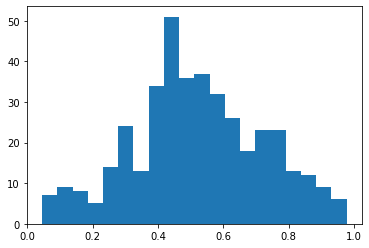

In [46]:
submission = pd.DataFrame(submission, columns=['filename', 'label'])
submission.sort_values('filename').to_csv('outputs/submission_w.csv', index=False)
plt.hist(submission.label, 20)
plt.show()